In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

def  Model_pred(ts,days,holidays):
    period= days
    m=Prophet()
    m.fit(ts)
    future=m.make_future_dataframe(period,freq='D')
    m1=Prophet(holidays=holidays,holidays_prior_scale=2,yearly_seasonality=20)
    forecast=m1.fit(ts).predict(future)
    fig=m1.plot_components(forecast) 
    return forecast

In [21]:
df1=pd.read_csv('C:\\Users\\asus\\Desktop\\US_Accidents_Dec20_Updated.csv')
df = df1.loc[:,['ID','Start_Time']]
def year(string):
    return int(string[0:4])
df['Year']=df['Start_Time'].apply(lambda x: year(x))
#creating month column
def month(string):
    return int(string[5:7])
df['Month']=df['Start_Time'].apply(lambda x: month(x))
#creating day column
def day(string):
    return int(string[8:10])
df['Day']=df['Start_Time'].apply(lambda x: day(x))
dft1 = df.copy() #把原先的数据copy一份，在副本中操作
dft1['date'] = pd.to_datetime(df[['Year',  'Month','Day']])
dft1['date']=pd.to_datetime(dft1['date'])
dft2 = dft1.groupby('date' , as_index = False).count()

dft2.index = pd.DatetimeIndex(dft2['date'])
dft2.drop(['Start_Time'] , axis = 1 ,inplace = True)
dft2.drop(['Year'] , axis = 1 ,inplace = True)
dft2.drop(['Month'] , axis = 1 ,inplace = True)
dft2.drop(['Day'] , axis = 1 ,inplace = True)
dft2.rename(columns={'ID':'Num_Acc'},inplace=True)
ts1=dft2[:1095]
ts1.rename(columns={'date':'ds','Num_Acc':'y'},inplace=True)
ts1.index = range(0,len(ts1)) 
print(ts1)


             ds    y
0    2016-02-08    4
1    2016-02-09    5
2    2016-02-10    7
3    2016-02-11    6
4    2016-02-12    2
...         ...  ...
1090 2019-02-12  292
1091 2019-02-13  235
1092 2019-02-14  277
1093 2019-02-15  250
1094 2019-02-16  102

[1095 rows x 2 columns]


In [27]:
dft2=dft2[:1460]

In [28]:
"""
添加holiday模型,其中窗口，都后滑upper_window=1,属于后滑1天，前面的窗口在典型的长假期间进行设置，比如国庆节upper_window=-7
"""
New_year=pd.DataFrame({
    'holiday':'New year',
    'ds': pd.to_datetime(['2020-01-01','2019-01-01','2018-01-01','2017-01-01','2016-01-01']),
    'lower_window': -1,
    'upper_window': 1,
})

Martin_Luther_King=pd.DataFrame({
    'holiday':'Martin Luther King',
    'ds': pd.to_datetime(['2020-01-21','2019-01-21','2018-01-21','2017-01-21','2016-01-21']),
    'lower_window': -1,
    'upper_window': 1,

})
President=pd.DataFrame({
    'holiday':'President',
    'ds': pd.to_datetime(['2020-02-18','2019-02-18','2018-02-18','2017-02-18','2016-02-18']),
    'lower_window': -1,
    'upper_window': 1,

})

Independence_Day=pd.DataFrame({
    'holiday':'Independence Day',
    'ds': pd.to_datetime(['2020-07-04','2019-07-04','2018-07-04','2017-07-04','2016-07-04']),
    'lower_window':-1,
    'upper_window':1,
})
Labour_Day=pd.DataFrame({
    'holiday':'Labour Day',
    'ds': pd.to_datetime(['2020-09-01','2019-09-01','2018-09-01','2017-09-01','2016-09-01']),
    'lower_window':-1,
    'upper_window':1,
})
Thanksgiving=pd.DataFrame({
    'holiday':'Thanksgiving',
    'ds': pd.to_datetime(['2020-11-28','2019-11-28','2018-11-28','2017-11-28','2016-11-28']),
    'lower_window':-1,
    'upper_window':1,
})
Christmas_Day=pd.DataFrame({
    'holiday':'Christmas Day',
    'ds': pd.to_datetime(['2020-12-25','2019-12-25','2018-12-25','2017-12-25','2016-12-25']),
    'lower_window':-1,
    'upper_window':1,
})

holidays=pd.concat((New_year,Martin_Luther_King,President,Independence_Day,Labour_Day,Thanksgiving,Christmas_Day))

In [29]:
dft2

,date,Num_Acc
date,,
2016-02-08,2016-02-08,4
2016-02-09,2016-02-09,5
2016-02-10,2016-02-10,7
2016-02-11,2016-02-11,6
2016-02-12,2016-02-12,2
...,...,...
2020-02-12,2020-02-12,305
2020-02-13,2020-02-13,351
2020-02-14,2020-02-14,341


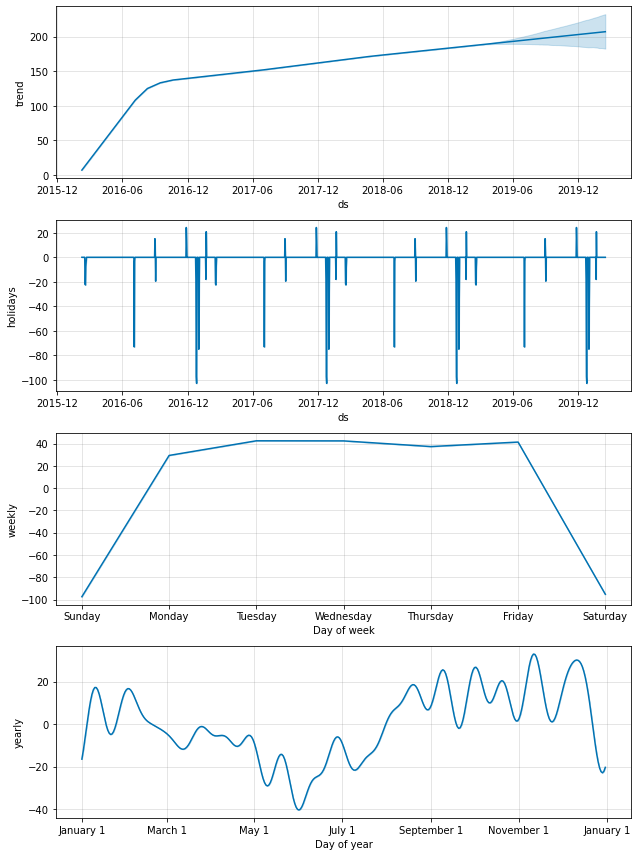

In [30]:
forecast1=Model_pred(ts1,365,holidays)

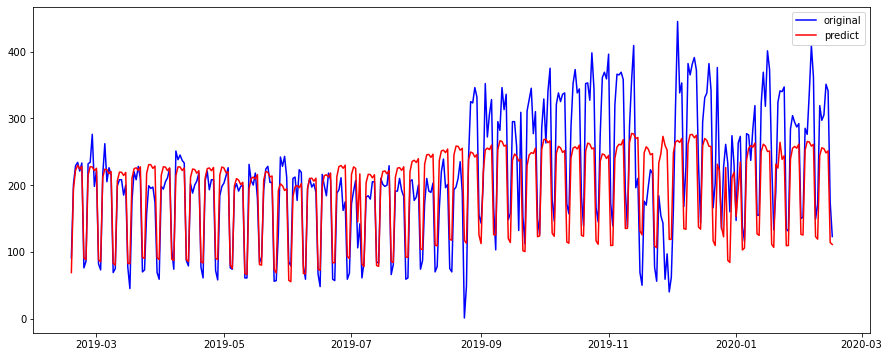

In [31]:
rcParams['figure.figsize']=15,6
forecast1.index = dft2.index
plt.plot (dft2.Num_Acc[1095:],color='blue',label='original')
plt.plot(forecast1['yhat'][1095:],color='red',label='predict')
plt.legend(loc='best')

In [32]:
ts5=dft2
from sklearn import metrics
from sklearn.metrics import r2_score#R square
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
 
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
 
# MSE
print('MSE:%.4f'%metrics.mean_squared_error(ts5.Num_Acc[1095:], forecast1['yhat'][1095:])) 
print('RMSE:%.4f'%np.sqrt(metrics.mean_squared_error(ts5.Num_Acc[1095:], forecast1['yhat'][1095:]))) 
# MAE
print('MAE:%.4f'%metrics.mean_absolute_error(ts5.Num_Acc[1095:], forecast1['yhat'][1095:])) 
# MAPE
print('MAPE:%.4f'%mape(ts5.Num_Acc[1095:],forecast1['yhat'][1095:]))
# SMAPE
print('SMAPE:%.4f'%smape(ts5.Num_Acc[1095:], forecast1['yhat'][1095:])) 
print('R2_SCORE:%.4f'%r2_score(ts5.Num_Acc[1095:],forecast1['yhat'][1095:]))

MSE:3252.9988
RMSE:57.0351
MAE:43.4308
MAPE:54.7060
SMAPE:22.1740
R2_SCORE:0.6240


In [33]:
forecast1['yhat'][1095:]

date
2019-02-17     68.984864
2019-02-18    194.547184
2019-02-19    222.151869
2019-02-20    229.559907
2019-02-21    224.152443
                 ...    
2020-02-12    254.436669
2020-02-13    248.197431
2020-02-14    251.267320
2020-02-15    113.886591
2020-02-16    111.082606
Name: yhat, Length: 365, dtype: float64